# Entendimento de negócio

## Contexto do projeto 
O dataset Telco Customer Churn contêm informações sobre uma empresa fictícia de telecomunicações que forneceu serviços de telefone residencial e Internet para 7043 clientes na Califórnia no terceiro trimestre. Eles indicam quais clientes deixaram, permaneceram ou se inscreveram para os seus serviços.

## Metas e objetivos
O objetivo deste projeto é (1) explorar os dados em busca de insights sobre a taxa de Churn da Telco, e (2) construir um modelo de machine learning capaz de predizer clientes que darão churn.

# Entendimento dos dados

## Features
|Coluna|Descrição|
|---|---|
|`customerID`|Identificador único dos clientes|
|`gender`|Gênero|
|`SeniorCitizen`|É idoso?|
|`Partner`|Possui parceiro?|
|`Dependents`|Possui dependentes?|
|`tenure`|Tempo de relacionamento (em meses)|
|`PhoneService`|Possui serviço telefonico?|
|`MultipleLines`|Possui multiplas linhas?(Sim, não, não possui serviço telefonico)|
|`InternetService`|Provedor de serviços de internet (DSL, Fibra ou não)|
|`OnlineSecurity`|Possui seguro online?|
|`OnlineBackup`|Possui backup online?|
|`DeviceProtection`|Possui proteção do dispositivo?|
|`TechSupport`|Tem suporte técnico?|
|`StreamingTV`|Possui streaming de TV?|
|`StreamingMovies`|Possui streaming de Filmes?|
|`Contract`|Tipo de contrato(mês-a-mês, anual ou bi-anual)|
|`PaperlessBilling`|Recebe boletos?|
|`PaymentMethod`|Método de pagamento|
|`MonthlyCharges`|Taxa de serviço|
|`TotalCharges`|Total pago pelo cliente|
|`Churn`|Alvo|

## Importação das bibliotecas e carregamento dos dados

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score, make_scorer, precision_recall_curve, confusion_matrix, matthews_corrcoef

# Pre-processing
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.utils.class_weight import compute_class_weight
from category_encoders import TargetEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Dark2')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## Qualidade dos dados

In [3]:
df.shape

(7043, 21)

In [4]:
df.nunique().sort_values()

Churn                  2
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PaperlessBilling       2
PhoneService           2
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
DeviceProtection       3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6531
customerID          7043
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [7]:
df.isnull().mean().sort_values(ascending = False)

TotalCharges        0.001562
customerID          0.000000
DeviceProtection    0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
OnlineBackup        0.000000
gender              0.000000
OnlineSecurity      0.000000
InternetService     0.000000
MultipleLines       0.000000
PhoneService        0.000000
tenure              0.000000
Dependents          0.000000
Partner             0.000000
SeniorCitizen       0.000000
Churn               0.000000
dtype: float64

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Análise Exploratória dos Dados

## Estatísticas descritivas

In [9]:
df.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.1621,0.3686,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.3711,24.5595,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.7617,30.0900,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.3004,2266.7714,18.80,401.45,1397.475,3794.7375,8684.80


In [10]:
df.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


## Comportamento do target

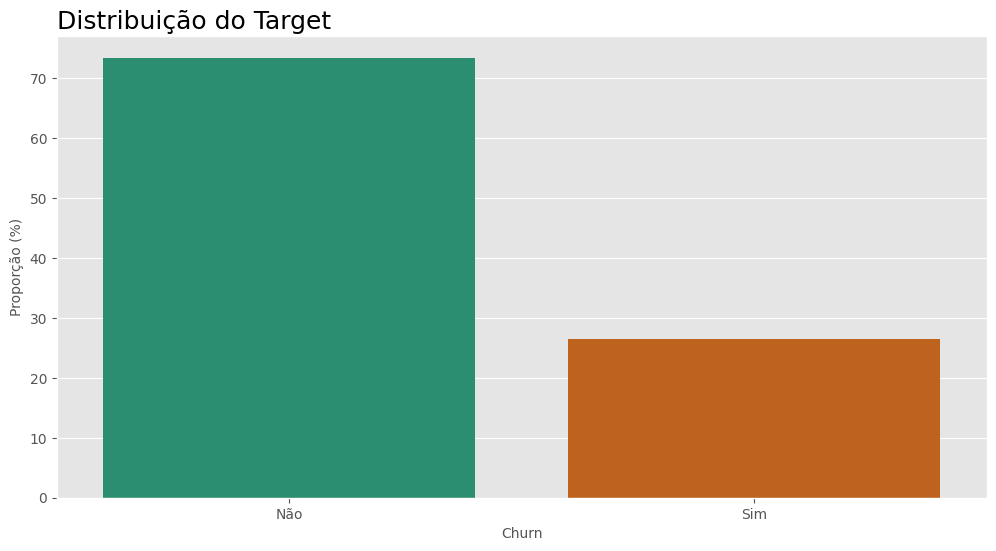

In [11]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df['Churn'], hue = df['Churn'], stat = 'percent')
ax.set_title("Distribuição do Target", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Churn", fontsize = 10)
ax.set_ylabel("Proporção (%)", fontsize = 10)
ax.set_xticklabels(['Não', 'Sim'])
plt.show()

A média da taxa de Churn no mercado de telefonia é entre 3% e 5%, a Telco possui uma taxa altíssima em comparação com outras empresas.

## Explorando hipóteses

### Churn x Tempo de Relacionamento
Quanto mais tempo permanecemos consumindo um serviços, muitas vezes por apego ou comodidade evitamos seu cancelamento. Em inicio de contrato o comportamento de estar atento e menos paciente com erros é comum, vamos trabalhar em cima da seguinte hipótese:

- $H_0$: O tempo de relacionamento com a empresa não tem efeito significativo na probabilidade de churn.
- $H_1$: Pessoas com menor tempo de relacionamento com a empresa têm maior probabilidade de churn.

In [12]:
from scipy.stats import mannwhitneyu

group_a = df[df['Churn'] == 'Yes']['tenure']
group_b = df[df['Churn'] == 'No']['tenure']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'less')

alpha = 0.05

if p_value < alpha:
    print("Rejeitamos H0: Clientes com menor tempo de relacionamento com a empresa tem maior probabilidade de churn.")
else:
    print("Não rejeitamos H0: O tempo de relacionamento com a empresa não tem efeito significante na probabilidade de churn.")

Rejeitamos H0: Clientes com menor tempo de relacionamento com a empresa tem maior probabilidade de churn.


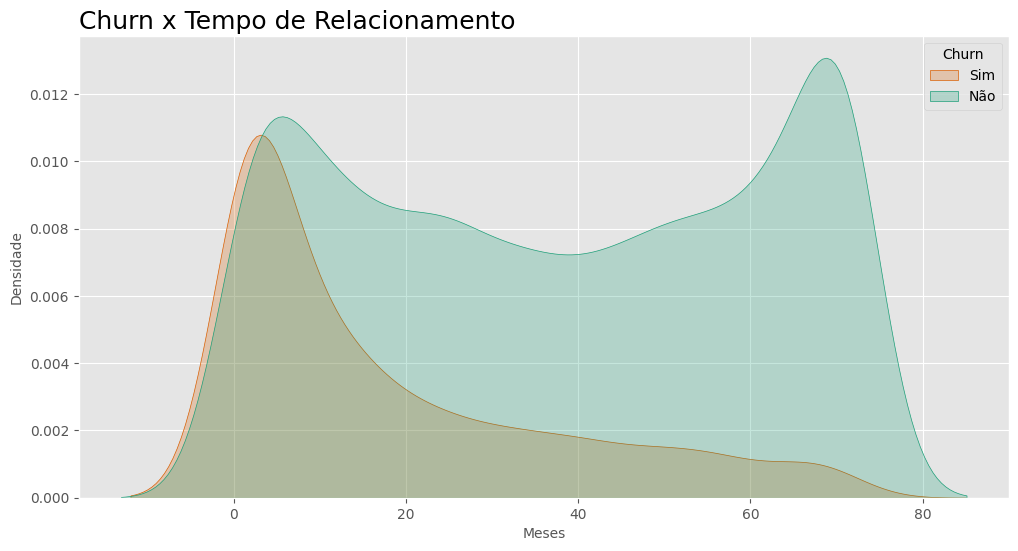

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(x = df['tenure'], hue = df['Churn'], fill = True)
ax.set_title("Churn x Tempo de Relacionamento", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Meses", fontsize = 10)
ax.set_ylabel("Densidade", fontsize = 10)
ax.legend(title = 'Churn', labels = ['Sim', 'Não'])
plt.show()

### Churn x Mensalidade
Pagar mais caro em um serviço é algo que também vai elevar o nível de exigência e diminuir o de paciência, vamos trabalhar na seguinte hipótese:

- $H_0$: O valor da mensalidade não tem efeito significativo na probabilidade de churn.
- $H_1$: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.

In [14]:
group_a = df[df['Churn'] == 'Yes']['MonthlyCharges']
group_b = df[df['Churn'] == 'No']['MonthlyCharges']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("Rejeitamos H0: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.")
else:
    print("Não rejeitamos H0: O valor da mensalidade não tem efeito significativo na probabilidade de churn.")

Rejeitamos H0: Clientes que pagam maiores mensalidades têm maior probabilidade de churn.


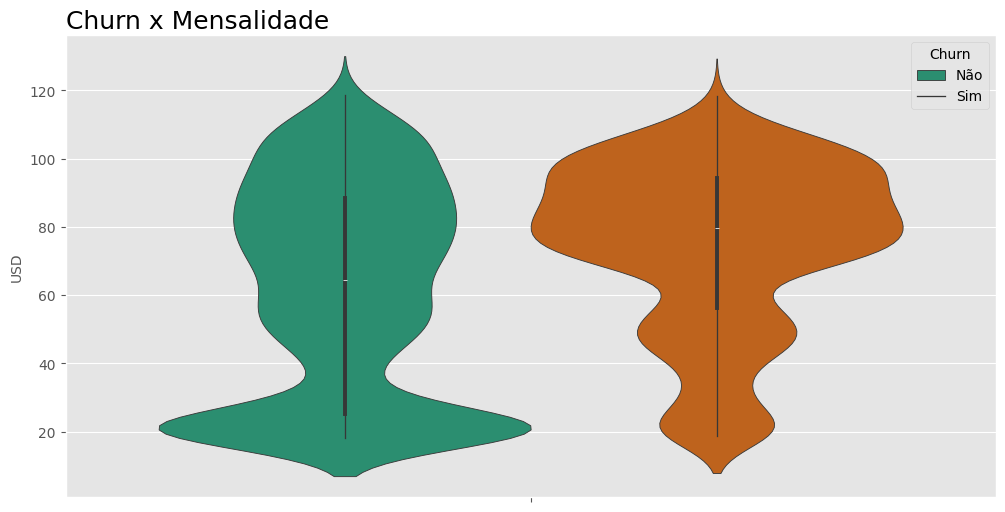

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.violinplot(y = df['MonthlyCharges'], hue = df['Churn'])
ax.set_title("Churn x Mensalidade", fontsize = 18, pad = 5, loc = 'left')
ax.set_ylabel("USD", fontsize = 10)
ax.legend(title = 'Churn', labels = ['Não', 'Sim'])
plt.show()

### Churn x Tipo de Contrato
A forma de contrato também pode estar ligada a probabilidade de Churn, vamos trabalhar também nessa hipótese:

- $H_0$: Churn é independente do Tipo de Contrato.
- $H_1$: Churn não é independente do Tipo de Contrato.

In [16]:
from scipy.stats import chi2_contingency

ct_1 = pd.crosstab(df['Contract'], df['Churn'])
chi2, p_value, dof, expected = chi2_contingency(ct_1)

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos H0: Churn não é independente do Tipo de Contrato.")
else:
    print("Não rejeitamos H0: Churn não é independente do Tipo de Contrato.")

Rejeitamos H0: Churn não é independente do Tipo de Contrato.


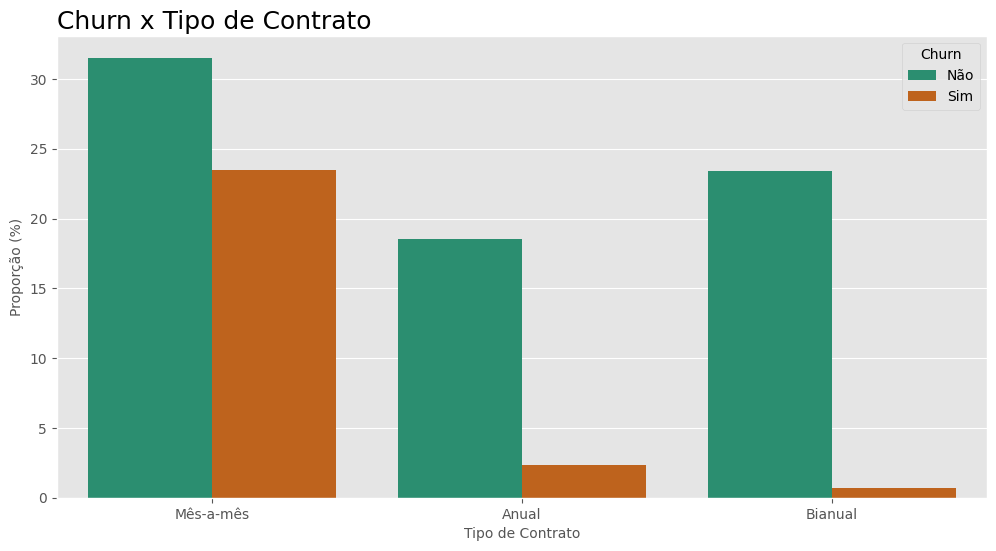

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df['Contract'], hue = df['Churn'], stat = 'percent')
ax.set_title("Churn x Tipo de Contrato", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Tipo de Contrato", fontsize = 10)
ax.set_ylabel("Proporção (%)", fontsize = 10)
ax.set_xticklabels(['Mês-a-mês', 'Anual', 'Bianual'])
ax.legend(title = 'Churn', labels = ['Não', 'Sim'])
plt.show()

### Churn x Método de Pagamento
A forma de pagamento também é outra variável que pode influenciar na probabilidade de Churn, vamos trabalhar essa hipótese:

- $H_0$: Churn é independente do Método de Pagamento.
- $H_1$: Churn não é independente do Método de Pagamento.

In [18]:
ct_2 = pd.crosstab(df['PaymentMethod'], df['Churn'])
chi2, p_value, dof, expected = chi2_contingency(ct_2)

alpha = 0.05
if p_value < alpha:
    print("Rejeitamos H0: Churn não é independente do Método de Pagamento.")
else:
    print("Não rejeitamos H0: Churn não é independente do Método de Pagamento.")

Rejeitamos H0: Churn não é independente do Método de Pagamento.


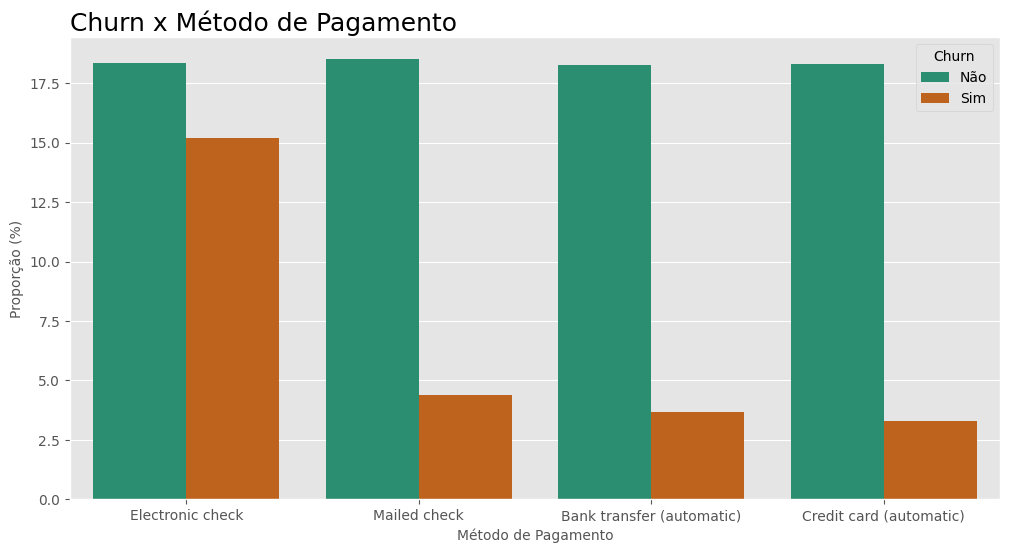

In [19]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df['PaymentMethod'], hue = df['Churn'], stat = 'percent')
ax.set_title("Churn x Método de Pagamento", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Método de Pagamento", fontsize = 10)
ax.set_ylabel("Proporção (%)", fontsize = 10)
ax.legend(title = 'Churn', labels = ['Não', 'Sim'])
plt.show()

## Conclusões da Análise Exploratória

- Clientes com menor tempo de relacionamento com a Telco tem maior probabilidade de Churn, são necessárias ações para aumentar a fidelização de clientes novos, especialmente no recorte dos primeiros 18 meses;
- Pessoas em planos com mensalidade maior tem maior probabilidade de Churn, é necessário checar o atendimento nestes planos e revisar os preços;
- Planos mensais são aquele com maior taxa de Churn, gerar incetivos para assinatura de planos mais longos pode ser uma solução;
- Pessoas adeptas de planos de pagamento automáticos tem uma probabilidade significamente menor de Churn, é interessante incentivar sua assinatura.

**Insights pós-análise:** É possível criar um plano de ação em forma de campanhas de marketing e novos planos de serviço para diminuir a taxa de Churn na Telco, algumas opções seriam (1) oferecer um plano anual com desconto caso o meio de pagamento escolhido seja Bank transnfer ou Credit card, (2) revisar preço e dar descontos para clientes com mais tempo de relacionamento que possuem planos mais caros para renovação anual ou bianual.

# Preparação dos dados

## Manipulação dos dados

In [20]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

## Pré-processamento

In [21]:
features = df.drop(columns = ['customerID', 'Churn'], axis = 1).columns.to_list()
target = 'Churn'

X = df[features]
y = df[target]

In [22]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=42)

In [23]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
num_features = ['tenure',  'MonthlyCharges', 'TotalCharges']

In [24]:
cat_transformer = Pipeline([
    ('cat_imput', CategoricalImputer(imputation_method = 'frequent')),
    ('cat_encoding', TargetEncoder())
])

num_transformer = Pipeline([
    ('num_imput', MeanMedianImputer(imputation_method='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

Considerando o desbalanceamento das classes (a classe target é menor que 30%) vamos usar meios para balancear. 

In [25]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

# Modelagem

## Escolhendo o modelo base

Vamos testar dois modelos, um ensemble (Random Forest) e outro de boosting (CatBoost):

In [26]:
def model_evaluation(models, X_train, y_train, X_val, y_val):
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:,1]

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_proba)
        mcc = matthews_corrcoef(y_val, y_pred)
        class_report = classification_report(y_val, y_pred)

        results[name] = {
            'Accuracy': acc,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'MCC': mcc,
            'Classification Report': class_report
        }

    return results

In [27]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose = 0, class_weights=weights_dict, random_state=21)
}

In [28]:
results = model_evaluation(models, X_train, y_train, X_val, y_val)

for model_name, metrics in  results.items():
    print(f"Modelo: {model_name}\n{'-' * 30}")
    print(f"Acurácia: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"MCC: {metrics['MCC']:.4f}")
    print(f"Classification Report: \n{metrics['Classification Report']}")

Modelo: Random Forest
------------------------------
Acurácia: 0.7906
F1 Score: 0.5590
ROC AUC: 0.8234
MCC: 0.4315
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1030
           1       0.64      0.49      0.56       379

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Modelo: CatBoost
------------------------------
Acurácia: 0.7644
F1 Score: 0.6295
ROC AUC: 0.8349
MCC: 0.4747
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1030
           1       0.55      0.74      0.63       379

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



Vamos seguir o projeto com o CatBoost, ele apresentou maior equiblirio na sensibilidade, apesar de perder um pouca da precisão para a classe alvo. Como métrica de otimização vou optar pelo MCC, é uma métrica que avalia a qualidade do modelo levando em conta todos os elementos da matriz de confusão, considerando sua robustez para problemas quando existe desbalanceamento entre as classes acredito ser a melhor escolha pro caso.

## Modelo otimizado

In [29]:
def objective(trial): 
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(
            verbose = 0,
            iterations = 1000,
            learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            depth = trial.suggest_int("depth", 1, 10),
            subsample = trial.suggest_float("subsample", 0.05, 1.0),
            colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.05, 1.0),
            min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100),
            class_weights=weights_dict, 
            random_state=42
        ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mcc = matthews_corrcoef(y_val, predictions)
    return mcc

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-09-05 09:51:57,259] A new study created in memory with name: no-name-11f8897a-0f1c-4c89-9eaa-d2c280e0780c
[I 2024-09-05 09:52:00,743] Trial 0 finished with value: 0.47712646404907594 and parameters: {'learning_rate': 0.037887653469367184, 'depth': 5, 'subsample': 0.6166244042435037, 'colsample_bylevel': 0.11764313901134661, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.47712646404907594.
[I 2024-09-05 09:52:03,933] Trial 1 finished with value: 0.43737035674061364 and parameters: {'learning_rate': 0.0017344064030699888, 'depth': 2, 'subsample': 0.43307110112675434, 'colsample_bylevel': 0.379004505545401, 'min_data_in_leaf': 41}. Best is trial 0 with value: 0.47712646404907594.
[I 2024-09-05 09:52:09,335] Trial 2 finished with value: 0.4794594529778586 and parameters: {'learning_rate': 0.02631539657209295, 'depth': 5, 'subsample': 0.4308449108042158, 'colsample_bylevel': 0.6883797368321964, 'min_data_in_leaf': 87}. Best is trial 2 with value: 0.4794594529778586.
[I 2024-

In [31]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor MCC: {study.best_value}")

Melhores hiperparâmetros: {'learning_rate': 0.008972199433787508, 'depth': 8, 'subsample': 0.06111651350523167, 'colsample_bylevel': 0.742008127122645, 'min_data_in_leaf': 98}
Melhor MCC: 0.5012794803670092


In [34]:
best_params = {'learning_rate': 0.008972199433787508, 
               'depth': 8, 
               'subsample': 0.06111651350523167, 
               'colsample_bylevel': 0.742008127122645, 
               'min_data_in_leaf': 98}

In [35]:
model = CatBoostClassifier(**best_params, 
                           verbose = 0, 
                           iterations = 1000, 
                           class_weights = weights_dict, 
                           random_state = 42)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('cat_encoding',
                                                                   TargetEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imput',
                                                                   MeanMedianImputer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000020D20DB4440>)])

In [37]:
y_pred_val = clf.predict(X_val)
y_proba_val = clf.predict_proba(X_val)[:,1]

In [39]:
print(f"Métricas - Conjunto de Validação (Otimizado)\n{'='*45}")
print(f"Acurácia: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_val):.4f}")
print(f"MCC: {matthews_corrcoef(y_val, y_pred_val):.4f}")

Métricas - Conjunto de Validação (Otimizado)
Acurácia: 0.7807
F1 Score: 0.6469
ROC AUC: 0.8329
MCC: 0.5013


In [40]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1030
           1       0.57      0.75      0.65       379

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



# Avaliação do modelo

## Métricas

In [42]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

In [45]:
print(f"Métricas - Conjunto de Teste \n{'='*30}")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")

Métricas - Conjunto de Teste 
Acurácia: 0.7786
F1 Score: 0.6502
ROC AUC: 0.8585
MCC: 0.5089


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1036
           1       0.55      0.77      0.64       373

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409



### Ajuste do limiar de decisão

In [46]:
thresholds = np.arange(0.0, 1.01, 0.01)

mccs = []

for threshold in thresholds:
    y_predict = (y_proba > threshold).astype(int)

    mcc = matthews_corrcoef(y_test, y_predict)
    mccs.append(mcc)

best_threshold = thresholds[np.argmax(mccs)]
best_mcc = max(mccs)

print(f"Melhor limiar: {best_threshold}")
print(f"Melhor MCC: {best_mcc:.4f}")

Melhor limiar: 0.6
Melhor MCC: 0.5240


## Validação cruzada

In [52]:
scoring = make_scorer(matthews_corrcoef)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Média Geral do MCC: {scores.mean()}")
print(f"Desvio Padrão do MCC: {scores.std()}")

Média Geral do MCC: 0.46573900380628486
Desvio Padrão do MCC: 0.01460535875365899


## Visualizações

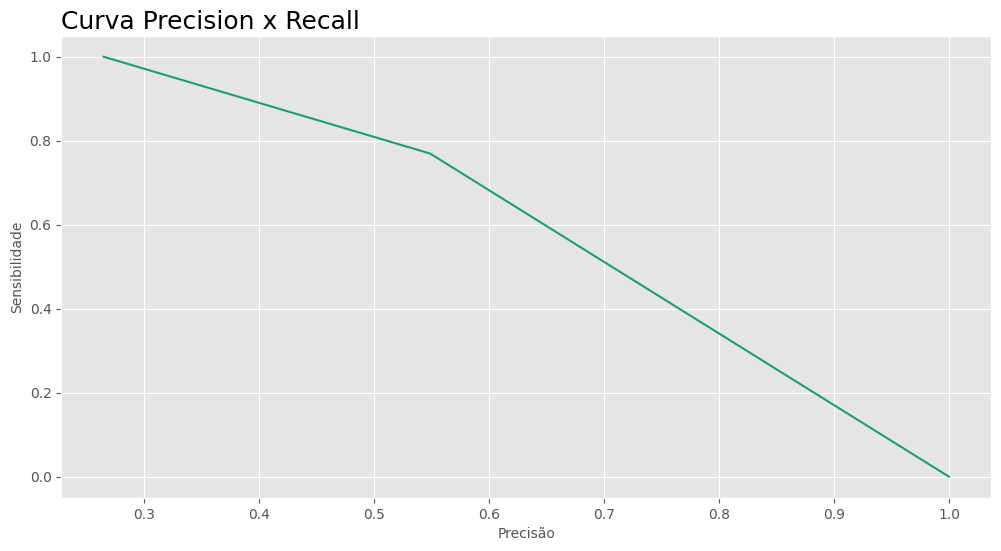

In [ ]:
precision, recall, thres = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Curva Precision x Recall", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Precisão", fontsize = 10)
ax.set_ylabel("Sensibilidade", fontsize = 10)
plt.show()

In [ ]:
curve = metrics.roc_curve(y_test, y_proba)

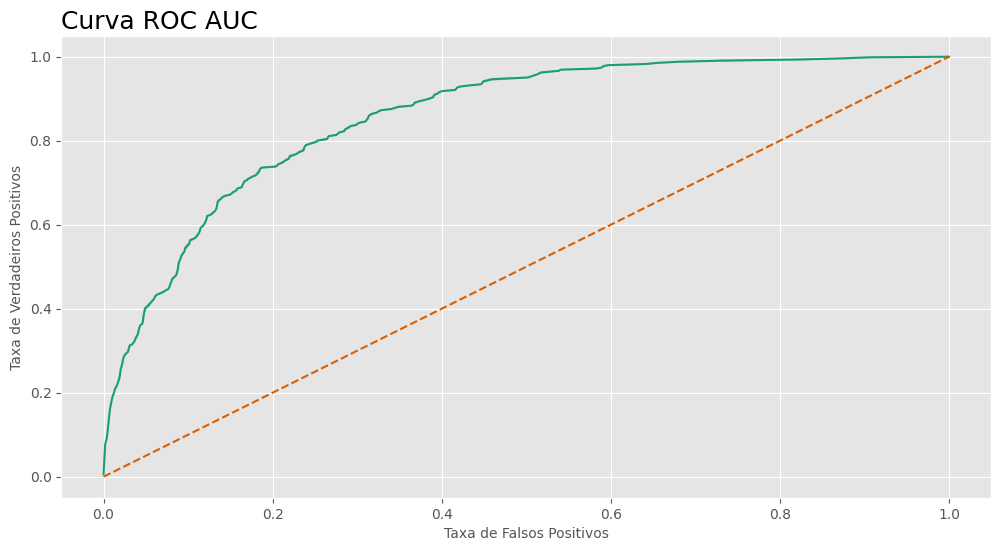

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curve[0], y = curve[1])
plt.plot([0, 1], [0, 1], '--')
ax.set_title("Curva ROC AUC", fontsize = 18, pad = 5, loc = 'left')
ax.set_xlabel("Taxa de Falsos Positivos", fontsize = 10)
ax.set_ylabel("Taxa de Verdadeiros Positivos", fontsize = 10)
plt.show()

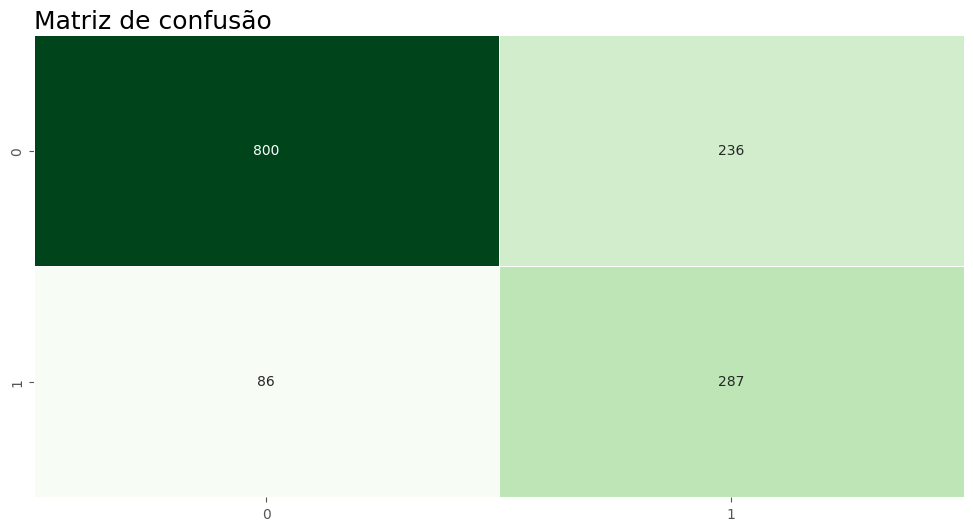

In [ ]:
cf = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cf, annot = True, fmt = 'd', linewidths=0.5, cmap = 'Greens', cbar = False)
ax.set_title("Matriz de confusão", fontsize = 18, pad = 5, loc = 'left')
plt.show()

## Conclusões sobre o modelo

O modelo demonstrou boa consistência nas métricas, sem indicios de overfitting, além de bons resultados na métrica de escolha, o MCC (acima de 0.50 no set de teste) e também nas outras métricas como o ROC AUC Score (0.8585). Como ajustes futuros talvez seja interessante uma otimização a partir do F1 Score que é uma métrica do balanço entre precisão e sensibilidade além de outros processos de feature engineering. 